In [1]:
import torch as T
import numpy as np
from matplotlib import pyplot as pt

import models
import util

device = T.device('cuda')

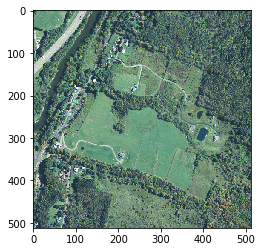

In [2]:
# load data and visualize the image

img, _, _ = util.load_data()
pt.imshow(img[:3].T)
pt.show()

In [3]:
# initialize model

epitome_size = 299
ep = models.EpitomeModel(epitome_size, 4).to(device)

In [ ]:
# train the model (best run on GPU)
# see figure in SI for outputs

n_batches = 10000
batch_size = 256
show_interval = 100

diversify = False # tiny image, no need to
mask_threshold = float('1e-8')
reset_threshold = 0.95

optimizer = T.optim.Adam(ep.parameters(), lr=0.003)

counter = T.zeros((ep.size, ep.size)).to(device)

for it in range(n_batches):
    w = np.random.randint(10,16)*2+1 # odd number 11 to 31
    
    #construct the batches
    batch = np.zeros((batch_size, 4, w, w))
    for b in range(batch_size):
        x = np.random.randint(img.shape[1]-w+1)
        y = np.random.randint(img.shape[2]-w+1)
        batch[b] = img[:,x:x+w,y:y+w]
    x = T.from_numpy(batch).to(device, T.float)
    
    optimizer.zero_grad()
    
    # compute p(x|s)p(s) and smooth
    e = ep(x) / (w/11)**2
    
    # extract worst-modeled quarter of data
    if diversify:
        indices = e.logsumexp((0,2,3)).topk(batch_size//4, largest=False, sorted=False).indices
        e = e[:,indices]
    
    # increment counters and compute mask
    posterior = e.view(-1, ep.size*ep.size).softmax(1).view(-1, ep.size, ep.size).mean(0)
    with T.no_grad(): counter += posterior
    mask = (counter > mask_threshold).float()
    
    # reset counters if threshold reached
    if (mask.mean() > reset_threshold):
        counter[:] = 0.
        mask[:] = 0.
    
    # compute log likelihood of data over unmasked positions (+const)
    loss = -T.logsumexp(e - 10000*mask, (0,2,3))
    loss.mean().backward()
    optimizer.step()
    
    # clamp parameters
    with T.no_grad(): 
        ep.ivar[:].clamp_(min=1, max=10**2)
        ep.prior[:] -= ep.prior.mean()
        ep.prior[:].clamp_(min=-4., max=4.)

    # show the means
    if it % show_interval == 0:
        pt.imshow(ep.mean.detach().cpu().numpy()[0,:3].T)
        pt.show()